## boilerplate code

In [1]:
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path
p_dir_input = Path("../data/canyon_gbg")

## load in observation data

In [44]:
# load in observation data
p_obs = p_dir_input / "GbgTorgg_canyon_QSresid.csv"
df_obs_raw = pd.read_csv(p_obs, sep=";")

# convert to datetime
ser_year = pd.to_datetime(df_obs_raw.year.astype(str) + "-01-01")
# df_obs_raw.dectime
ser_dt=ser_year+pd.to_timedelta(df_obs_raw.dectime, unit="D").dt.round("30T")
df_obs=df_obs_raw.copy()
df_obs["datetime"]=ser_dt
df_obs.set_index("datetime", inplace=True)
df_obs.drop(columns=["year", "dectime"], inplace=True)
df_obs[df_obs.index.duplicated()]
ser_qg = df_obs.dryQSresid.rename("QG_obs")
ser_qg[ser_qg.index.duplicated()]
#ser_qg = ser_qg.reset_index()

datetime
2004-02-06 18:00:00   NaN
2004-02-06 20:00:00   NaN
2004-02-06 21:00:00   NaN
2004-02-06 22:00:00   NaN
2004-02-06 23:00:00   NaN
                       ..
2004-08-24 17:00:00   NaN
2004-08-24 18:00:00   NaN
2004-08-24 19:00:00   NaN
2004-08-24 20:00:00   NaN
2004-08-24 21:00:00   NaN
Name: QG_obs, Length: 3037, dtype: float64

## simulations

In [3]:

p_runcontrol = p_dir_input / "RunControl.nml"
df_state_base = sp.init_supy(p_runcontrol)
df_forcing = sp.load_forcing_grid(p_runcontrol, 1)

2024-04-16 15:49:36,769 - SuPy - INFO - All cache cleared.


2024-04-16 15:49:38,095 - SuPy - INFO - All cache cleared.


In [4]:
# OHM
df_state_ohm = df_state_base.copy()
df_state_ohm.storageheatmethod = 1
df_state_ohm.netradiationmethod = 3
df_output_ohm, df_state_ohm_final = sp.run_supy(df_forcing, df_state_ohm)

2024-04-16 15:49:45,321 - SuPy - INFO - ====================
2024-04-16 15:49:45,322 - SuPy - INFO - Simulation period:
2024-04-16 15:49:45,323 - SuPy - INFO -   Start: 2004-01-01 00:05:00
2024-04-16 15:49:45,325 - SuPy - INFO -   End: 2004-08-23 22:00:00
2024-04-16 15:49:45,327 - SuPy - INFO - 
2024-04-16 15:49:45,328 - SuPy - INFO - No. of grids: 1
2024-04-16 15:49:45,329 - SuPy - INFO - SuPy is running in serial mode
2024-04-16 15:50:58,787 - SuPy - INFO - Execution time: 73.5 s
2024-04-16 15:50:58,788 - SuPy - INFO - ====================



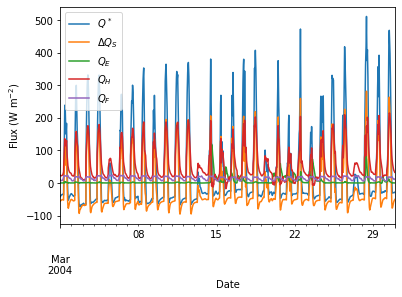

In [5]:
#df_output_base.head()
df_output_ohm_suews = df_output_ohm['SUEWS']
dict_var_disp = {
    'QN': '$Q^*$',
    'QS': r'$\Delta Q_S$',
    'QE': '$Q_E$',
    'QH': '$Q_H$',
    'QF': '$Q_F$',
    'Kdown': r'$K_{\downarrow}$',
    'Kup': r'$K_{\uparrow}$',
    'Ldown': r'$L_{\downarrow}$',
    'Lup': r'$L_{\uparrow}$',
    'Rain': '$P$',
    'Irr': '$I$',
    'Evap': '$E$',
    'RO': '$R$',
    'TotCh': '$\Delta S$',
}
ax_output = df_output_ohm_suews\
    .loc[1]\
    .loc['2004 3 1':'2004 3 30',
         ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot()
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

In [13]:
df_state_base.filter(like='frac')

var     irrfracpaved irrfracbldgs irrfracevetr irrfracdectr irrfracgrass  \
ind_dim            0            0            0            0            0   
grid                                                                       
1                0.0          0.0          0.0          0.0          0.0   

var     irrfracbsoil irrfracwater sw_dn_direct_frac  \
ind_dim            0            0                 0   
grid                                                  
1                0.0          0.0              0.45   

var     veg_contact_fraction_const snowfrac  ... icefrac building_frac         \
ind_dim                          0     (0,)  ...    (6,)          (0,)   (1,)   
grid                                         ...                                
1                              0.0      0.0  ...     0.2         0.538  0.404   

var            veg_frac             wall_specular_frac                
ind_dim   (2,)     (0,)   (1,) (2,)             (0, 0) (0, 1) (0, 2)  
grid                                                                  
1        0.034    0.043  0.011  0.0                0.0    0.0    0.0  

[1 rows x 32 columns]

In [7]:
#Run with SS and EHC
# modify the depth of the wall layers
ar_depth = np.repeat(np.array([[0.087, 0.0497, 0.0497, 0.001, 0.001]]), 3, axis=0).flatten()
df_state_base.loc[:, "dz_wall"] = ar_depth

# modify the heat capacity of the wall layers
ar_cp = np.repeat(np.array([[1.047, 1.5, 1.5, 1.2, 1.2]])*1e6, 3, axis=0).flatten()
df_state_base.loc[:, "cp_wall"] = ar_cp

# modify the thermal conductivity of the wall layers
ar_k = np.repeat(np.array([[0.761, 0.93, 0.93, 0.63, 0.63]]) , 3, axis=0).flatten()
df_state_base.loc[:, "k_wall"] = ar_k

# modify the depth of the vertical layers
ar_depth = np.repeat(np.array([[0.1, 0.1, 0.5, 2, 3]]), 7, axis=0).flatten()
df_state_base.loc[:, "dz_surf"] = ar_depth

df_output_ehcss, df_state_ehcss_final = sp.run_supy(df_forcing, df_state_base)

2024-04-16 15:51:30,055 - SuPy - INFO - ====================
2024-04-16 15:51:30,056 - SuPy - INFO - Simulation period:
2024-04-16 15:51:30,057 - SuPy - INFO -   Start: 2004-01-01 00:05:00
2024-04-16 15:51:30,058 - SuPy - INFO -   End: 2004-08-23 22:00:00
2024-04-16 15:51:30,060 - SuPy - INFO - 
2024-04-16 15:51:30,061 - SuPy - INFO - No. of grids: 1
2024-04-16 15:51:30,062 - SuPy - INFO - SuPy is running in serial mode
2024-04-16 16:49:20,180 - SuPy - INFO - Execution time: 3470.1 s
2024-04-16 16:49:20,182 - SuPy - INFO - ====================



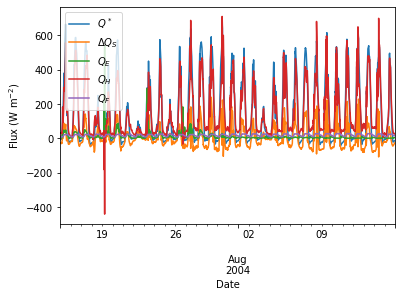

In [17]:
#df_output_base.head()
df_output_ehcss_suews = df_output_ehcss['SUEWS']
dict_var_disp = {
    'QN': '$Q^*$',
    'QS': r'$\Delta Q_S$',
    'QE': '$Q_E$',
    'QH': '$Q_H$',
    'QF': '$Q_F$',
    'Kdown': r'$K_{\downarrow}$',
    'Kup': r'$K_{\uparrow}$',
    'Ldown': r'$L_{\downarrow}$',
    'Lup': r'$L_{\uparrow}$',
    'Rain': '$P$',
    'Irr': '$I$',
    'Evap': '$E$',
    'RO': '$R$',
    'TotCh': '$\Delta S$',
}
ax_output = df_output_ehcss_suews\
    .loc[1]\
    .loc['2004 7 15':'2004 8 15',
         ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot()
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

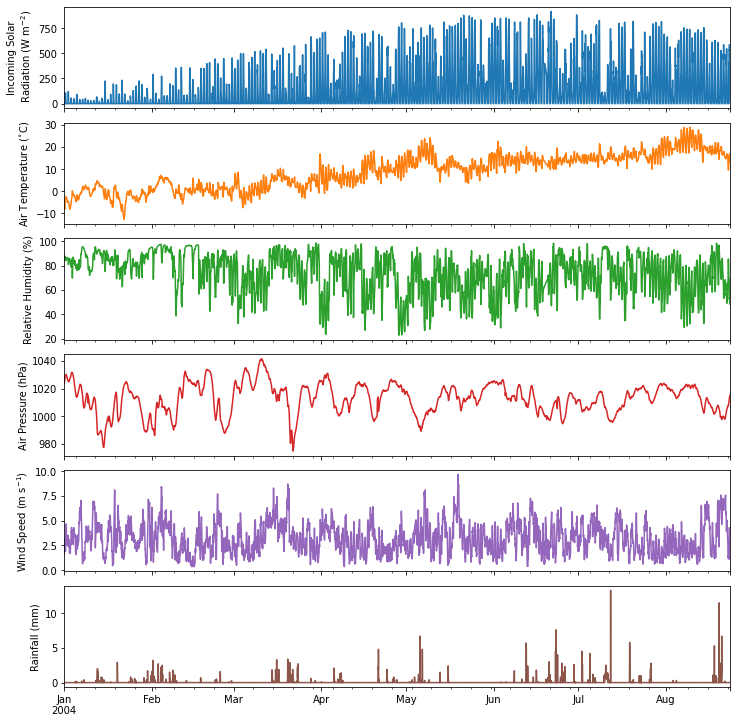

In [18]:
# Examine input data
list_var_forcing = [
    "kdown",
    "Tair",
    "RH",
    "pres",
    "U",
    "rain",
]
dict_var_label = {
    "kdown": "Incoming Solar\n Radiation ($ \mathrm{W \ m^{-2}}$)",
    "Tair": "Air Temperature ($^{\circ}}$C)",
    "RH": r"Relative Humidity (%)",
    "pres": "Air Pressure (hPa)",
    "rain": "Rainfall (mm)",
    "U": "Wind Speed (m $\mathrm{s^{-1}}$)",
}

# df_forcing=df_forcing.loc[s2: e].iloc[1:]


# plot forcing data
df_plot_forcing_x = df_forcing.loc[:, list_var_forcing].copy().shift(
    -1).dropna(how='any')
df_plot_forcing = df_plot_forcing_x.resample('1h').mean()
df_plot_forcing['rain'] = df_plot_forcing_x['rain'].resample('1h').sum()

axes = df_plot_forcing.plot(
    subplots=True,
    figsize=(10, 12),
    legend=False,
)
fig = axes[0].figure
fig.tight_layout()
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')
for ax, var in zip(axes, list_var_forcing):
    ax.set_ylabel(dict_var_label[var])

In [15]:
df_state_base.loc[:,"k_surf"]
df_state_base.filter(like='method').T

,grid,1
var,ind_dim,
diagmethod,0,0
emissionsmethod,0,2
faimethod,0,0
netradiationmethod,0,1003
roughlenheatmethod,0,2
roughlenmommethod,0,2
smdmethod,0,0
stabilitymethod,0,2
storageheatmethod,0,5


In [19]:
# Here we can modify to get better fit...
#df_state_ehc = df_state_base.copy()
#df_state_ehc.storageheatmethod = 5

# modify the depth of the vertical layers
#ar_depth = np.repeat(np.array([[0.1, 0.1, 0.5, 2, 3]]), 7, axis=0).flatten()
#df_state_ehc.loc[:, "dz_surf"] = ar_depth

# # modify the heat capacity of the vertical layers
# ar_cp = np.repeat(np.array([[2.2, 2.2, 2.2, 2.2, 2.2]])*1e6, 7, axis=0).flatten()
# df_state_ehc.loc[:, "cp_surf"] = ar_cp

# # modify the thermal conductivity of the vertical layers
# ar_k = np.repeat(np.array([[1.1, 1.1, 1.1, 1.1, 1]]) * 1.5, 7, axis=0).flatten()
# df_state_ehc.loc[:, "k_surf"] = ar_k

#df_output_ehc, df_state_final = sp.run_supy(df_forcing, df_state_ehc)

### result comparison

<AxesSubplot:xlabel='datetime'>

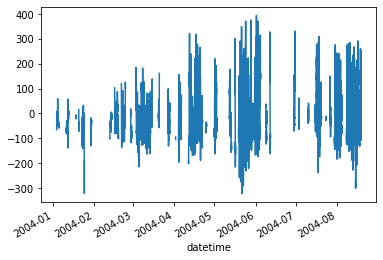

In [45]:
ser_qg.plot()

In [46]:
df_comp = (
    pd.concat([df_output_ohm, df_output_ehcss], axis=1, keys=["base", "ehc"])
    .swaplevel(axis=1, i=1, j=0)
    .swaplevel(axis=1, i=1, j=2)
    .sort_index(axis=1)
)
df_comp_qs = df_comp.loc[1, "SUEWS"].QS
df_comp_qs = df_comp_qs.assign(obs=ser_qg).dropna()
df_comp_qs.loc['2004-8-08':'2004-8-19'].plot()

ValueError: cannot reindex on an axis with duplicate labels

In [31]:
df_comp_qs.head()


,base,ehc
datetime,,
2004-01-01 00:05:00,-64.887896,-180.025544
2004-01-01 00:10:00,-64.526188,-176.382421
2004-01-01 00:15:00,-64.179551,-172.253343
2004-01-01 00:20:00,-63.847357,-168.333986
2004-01-01 00:25:00,-63.529005,-164.708167


In [13]:
ax = df_comp_qs.plot.scatter(x="obs", y="ehc", alpha=0.2, style="..", title="EHC")
_ = ax.set_aspect("equal", "box")
_ = ax.set_xlim(-200, 400)
_ = ax.set_ylim(-200, 400)
_ = ax.plot([-200, 400], [-200, 400], "k--")

NameError: name 'df_comp_qs' is not defined

In [14]:
ax = df_comp_qs.plot.scatter(x="obs", y="base", alpha=0.2, style="..", title="OHM")
_ = ax.set_aspect("equal", "box")
_ = ax.set_xlim(-200, 400)
_ = ax.set_ylim(-200, 400)
_ = ax.plot([-200, 400], [-200, 400], "k--")

NameError: name 'df_comp_qs' is not defined

In [15]:
# compare the performance of the two simulations
df_comp_qs.corr()


NameError: name 'df_comp_qs' is not defined

In [16]:
df_comp_qs.corr(method="spearman")

NameError: name 'df_comp_qs' is not defined

In [17]:
# calculate RMSE for the two simulations
rmse_base = np.sqrt(((df_comp_qs.obs - df_comp_qs.base) ** 2).mean())
rmse_ehc = np.sqrt(((df_comp_qs.obs - df_comp_qs.ehc) ** 2).mean())
rmse_base, rmse_ehc


NameError: name 'df_comp_qs' is not defined